In [ ]:
import pandas as pd

for file in all_files:
    try:
        df = pd.read_csv(file, delimiter=",", encoding="utf-8", on_bad_lines="skip")
        print(f"✅ Loaded {file} successfully! Shape: {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file}: {e}")


✅ Loaded /content/drive/MyDrive/OceansLSTM/surface_height.csv successfully! Shape: (7, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/zonal current.csv successfully! Shape: (8, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/vertical velocity at t points.csv successfully! Shape: (8, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/sea surface temperature.csv successfully! Shape: (7, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/dry blub temperature.csv successfully! Shape: (8, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/potential temperature.csv successfully! Shape: (8, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/surface heigh.csv successfully! Shape: (7, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/salinity.csv successfully! Shape: (8, 1)
✅ Loaded /content/drive/MyDrive/OceansLSTM/surface height on  t cell.csv successfully! Shape: (7, 1)


In [ ]:
import pandas as pd
import numpy as np


pd.set_option('display.float_format', '{:.13f}'.format)


file_paths = [
    "/content/drive/MyDrive/OceansLSTM/surface_height.csv",
    "/content/drive/MyDrive/OceansLSTM/zonal current.csv",
    "/content/drive/MyDrive/OceansLSTM/vertical velocity at t points.csv",
    "/content/drive/MyDrive/OceansLSTM/sea surface temperature.csv",
    "/content/drive/MyDrive/OceansLSTM/dry blub temperature.csv",
    "/content/drive/MyDrive/OceansLSTM/potential temperature.csv",
    "/content/drive/MyDrive/OceansLSTM/surface heigh.csv",
    "/content/drive/MyDrive/OceansLSTM/salinity.csv",
    "/content/drive/MyDrive/OceansLSTM/surface height on  t cell.csv",
]


dfs = {}

for file in file_paths:
    try:

        file_name = file.split("/")[-1].replace(".csv", "").replace(" ", "_")


        df = pd.read_csv(file, skiprows=14, header=None, sep=None, engine='python')


        df.replace(['-999', '99999', 'NaN', 'Err', 'error', 'inf', '-inf', ''], np.nan, inplace=True)


        if df.shape[1] == 6:
            df.columns = ['DATETIME', 'TIME', 'LON', 'LAT', 'DEP', file_name]
            df.drop(['DATETIME', 'DEP'], axis=1, inplace=True)
        elif df.shape[1] == 5:
            df.columns = ['DATETIME', 'TIME', 'LON', 'LAT', file_name]
            df.drop(['DATETIME'], axis=1, inplace=True)
        else:
            print(f"⚠️ Skipping {file} due to unexpected format.")
            continue


        dfs[file] = df
        print(f"✅ Loaded {file} | Shape: {df.shape}")

    except Exception as e:
        print(f"❌ Error loading {file}: {e}")


merged_df = None
for file, df in dfs.items():
    if merged_df is None:
        merged_df = df  # First dataset
    else:
        merged_df = pd.merge(merged_df, df, on=['TIME', 'LON', 'LAT'], how='outer')


error_values = [-9999999999999999455752309870428160.0000000000000, -999999.0, -9999.0]


merged_df.replace(error_values, np.nan, inplace=True)


merged_df = merged_df.bfill().ffill().interpolate()



merged_df = merged_df.bfill().ffill().interpolate()


print(merged_df.head())
print(f"✅ Final merged dataset shape: {merged_df.shape}")


✅ Loaded /content/drive/MyDrive/OceansLSTM/surface_height.csv | Shape: (20379, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/zonal current.csv | Shape: (17468, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/vertical velocity at t points.csv | Shape: (17468, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/sea surface temperature.csv | Shape: (20379, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/dry blub temperature.csv | Shape: (140, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/potential temperature.csv | Shape: (17468, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/surface heigh.csv | Shape: (20379, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/salinity.csv | Shape: (17468, 4)
✅ Loaded /content/drive/MyDrive/OceansLSTM/surface height on  t cell.csv | Shape: (17467, 4)
               TIME              LON              LAT   surface_height  \
0 374.2420000000000 81.5000000000000 17.5000000000000 10.7213000000000   
1 374.2420000000000 81.5000000000000 18.5000000000000 10.7213000000000   
2 

In [ ]:
merged_df.to_csv('/content/merged_dataset.csv', index=False)


In [ ]:
from google.colab import files
files.download('/content/merged_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


df = pd.read_csv("/content/merged_dataset.csv")


scaler = MinMaxScaler()
df.iloc[:, 3:] = scaler.fit_transform(df.iloc[:, 3:])


sequence_length = 10
features = df.iloc[:, 3:].values

X, y = [], []
for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(features[i + sequence_length])

X, y = np.array(X), np.array(y)


model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(X.shape[2])
])

model.compile(optimizer='adam', loss='mse')


model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)


model.save("/mnt/data/lstm_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - loss: 0.0098 - val_loss: 0.0011
Epoch 2/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0018 - val_loss: 6.9951e-04
Epoch 3/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 0.0013 - val_loss: 6.0551e-04
Epoch 4/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0011 - val_loss: 5.8710e-04
Epoch 5/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 9.8413e-04 - val_loss: 5.3807e-04
Epoch 6/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 8.9101e-04 - val_loss: 5.3231e-04
Epoch 7/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 8.2082e-04 - val_loss: 4.6682e-04
Epoch 8/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 7.5902e-04 - val_loss: 4.3036e-04
Epoch 9/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 7.1782e-04 - val_loss: 5.8915e-04
Epoch 10/10
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 6.8223e-04 - val_loss: 4.7153e-04


In [ ]:
model.save("my_model.keras")

In [ ]:

num_samples, timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)


X_train_scaled = X_train_scaled.reshape(num_samples, timesteps, num_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape)


In [ ]:
y_pred_scaled = model.predict(X_test_scaled)


474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


if 'scaler' in globals():
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_original = scaler.inverse_transform(y_test)
else:
    y_pred = y_pred_scaled
    y_test_original = y_test


mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")


MAE: 0.014577763117104493
MSE: 0.0007072556647214549
R² Score: 0.8645059929350191


In [ ]:
print(df.head)

<bound method NDFrame.head of                      TIME              LON              LAT  surface_height  \
0       374.2420000000000 81.5000000000000 17.5000000000000 0.6774252704933   
1       374.2420000000000 81.5000000000000 18.5000000000000 0.6774252704933   
2       374.2420000000000 82.5000000000000 16.5000000000000 0.6774252704933   
3       374.2420000000000 82.5000000000000 17.5000000000000 0.6774252704933   
4       374.2420000000000 82.5000000000000 18.5000000000000 0.6774252704933   
...                   ...              ...              ...             ...   
75829 44557.5000000000000 84.0844000000000 17.0027000000000 0.5870163212910   
75830 44557.5000000000000 84.0844000000000 17.3568000000000 0.5870163212910   
75831 44557.5000000000000 84.0844000000000 17.7178000000000 0.5870163212910   
75832 44557.5000000000000 84.0844000000000 18.0858000000000 0.5870163212910   
75833 44557.5000000000000 84.0844000000000 18.4608000000000 0.5870163212910   

        zonal_current

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 0.0127 - val_loss: 0.0052
Epoch 2/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 3/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 4/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 5/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 7/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 8/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 9/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 10/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 11/50
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 12

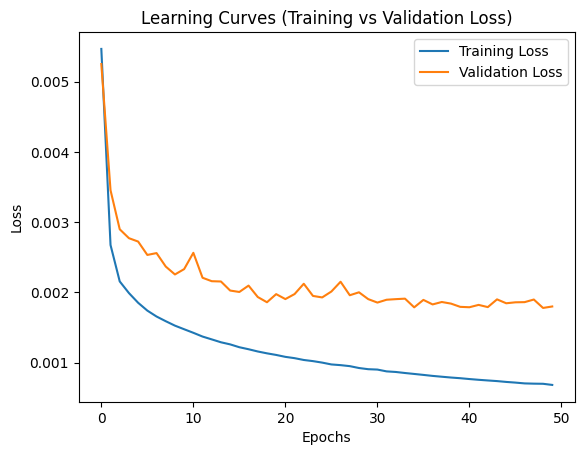

237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
MAE: 0.014829120456637432
MSE: 0.0009917209912545884
R² Score: 0.7852341525870549
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming df is already loaded and preprocessed
df = pd.read_csv('/content/drive/MyDrive/OceansLSTM/processed_dataset.csv')


# Scaling the features
scaler = MinMaxScaler()
df.iloc[:, 3:] = scaler.fit_transform(df.iloc[:, 3:])

sequence_length = 10
features = df.iloc[:, 3:].values

X, y = [], []
for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(features[i + sequence_length])

X, y = np.array(X), np.array(y)

# Step 1: Split Data into Train, Validation, Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)  # Time series data, no shuffle
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Step 2: Model Training with Validation
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(X_train.shape[2])
])

model.compile(optimizer='adam', loss='mse')

# Store history for plotting learning curves
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Step 3: Plot Learning Curves (Training vs Validation Loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves (Training vs Validation Loss)')
plt.show()

# Step 4: Evaluate the Model on the Test Set
y_pred_scaled = model.predict(X_test)

# Inverse scaling if applicable
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Step 5: Compute Evaluation Metrics
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

# Step 6: Cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Store cross-validation results
cv_mae, cv_mse, cv_r2 = [], [], []
for train_idx, val_idx in tscv.split(X):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)
    y_pred_cv = model.predict(X_val_cv)

    # Inverse scaling for evaluation
    y_pred_cv = scaler.inverse_transform(y_pred_cv)
    y_val_cv = scaler.inverse_transform(y_val_cv)

    # Compute metrics for cross-validation fold
    cv_mae.append(mean_absolute_error(y_val_cv, y_pred_cv))
    cv_mse.append(mean_squared_error(y_val_cv, y_pred_cv))
    cv_r2.append(r2_score(y_val_cv, y_pred_cv))

# Cross-validation results
print(f"Cross-Validation MAE: {np.mean(cv_mae)}")
print(f"Cross-Validation MSE: {np.mean(cv_mse)}")
print(f"Cross-Validation R²: {np.mean(cv_r2)}")
